In [382]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.feature_selection import SelectKBest, mutual_info_classif


# Cleaning

In [383]:
df = pd.read_csv('critical_mention_report_2023-02-17.csv')
date_format = "%b %d, %Y %I:%M %p %Z"

In [384]:
#Cleaning Data
df = df.dropna(axis=1, how='all')

df = df.drop(['Online + Print Author', 'Online + Print Source Page', 'Text', 'URL', 'Last Updated', 'Text ID', 'Thumbnail', 'Clip ID', 'License Name', 'Copyright'], axis=1)

#for exporting cleaned data
def export_dropna(df):
    df.to_csv('score_data_cleaned.csv', index=False)
#export_dropna(df)


In [385]:
#Making the Dates Datetime objects
date_format_1 = '%m/%d/%Y %I:%M:%S %p'
date_format_2 = '%I:%M %p'

# Define a function to convert a single time string to a datetime object, removing 'CDT'
def convert_time_string(time_str):
    # Remove the last 4 characters (' CDT') from the time string
    time_str = time_str[:-4]
    
    # Parse the time string to a datetime object without timezone information
    datetime_obj = datetime.strptime(time_str, date_format_2)
    
    return datetime_obj

# Apply the function to the 'time_str' column to create a new 'datetime' column
df['Broadcast Time'] = df['Broadcast Time'].apply(convert_time_string)


df['Date and Time'] = df['Time Clip'].apply(lambda x: datetime.strptime(x, date_format_1))

In [386]:
#Getting rid of Local Audience and Publicity Value, after talking to Lori she said that these were not necesssary since 1/4 of the data did not exist

df.groupby('Estimated Local Audience').size() # 2595 values that are zero
df.groupby('Estimated Local Publicity Value').size()
len(df) #8292 total values

df = df.drop(['Estimated Local Audience', 'Estimated Local Publicity Value'], axis=1)


# Dissecting Different types of Press Content

In [387]:
df['Press Content'] = pd.Series([[]] * len(df))
df['Keywords'] = df['Keywords'].astype(str)

# Ask SCORE

In [388]:
#Creates an ASK SCORE column by checking if ASK SCORE is mentioned in the description of the clip
def add_ask_score(keywords):
    if 'ask score' in keywords.lower():
        return True
    else:
        return False
    
df['Ask SCORE'] = df['Plain Text'].apply(lambda x: add_ask_score(x))

df.groupby('Ask SCORE').size()

Ask SCORE
False    8248
True       44
dtype: int64

# Radio PSA

In [389]:
#The Radio PSAs were outlined as Radio in Media Type. 
def add_radio(x):
    if x == 'RADIO':
        return True
    else:
        return False
    
df['Radio PSA'] = df['Media Type'].apply(lambda x: add_radio(x))

df.groupby('Radio PSA').size()

Radio PSA
False    5768
True     2524
dtype: int64

# Press Release

In [390]:
#Press Releases have 'Press' in the Online + Print Source Name, so I filtered for that when trying to find out which ones were in this category
def add_press_release(x):
    if isinstance(x, str) and 'Press' in x:
        return True
    else:
        return False
    
df['Press Release'] = df['Online + Print Source Name'].apply(lambda x: add_press_release(x))

df.groupby('Press Release').size()

Press Release
False    8100
True      192
dtype: int64

# Local Chapter Workshops

In [391]:
#Filtered the Text description of the clip to see if it related to a workshop of some kind
def add_chapter_workshops(text):
    if 'workshops' in text.lower():
        return True
    else:
        return False
    
df['Local Chapter Workshops'] = df['Plain Text'].apply(lambda x: add_chapter_workshops(x))

df.groupby('Local Chapter Workshops').size()

Local Chapter Workshops
False    7622
True      670
dtype: int64

# Pitch Placements

In [392]:
#Filtered the Text description of the clip to see if it related to a pitch competition of some kind
def add_pitch_placements(text):
    if 'pitch' in text.lower():
        return True
    else:
        return False
    
df['Pitch Placements'] = df['Plain Text'].apply(lambda x: add_pitch_placements(x))

df.groupby('Pitch Placements').size()

Pitch Placements
False    8002
True      290
dtype: int64

# Charts

In [393]:
charts = pd.DataFrame()

# Titles
charts['Press Content'] = ['Ask SCORE', 'Radio PSA', 'Press Release', 'Local Chapter Workshops', 'Pitch Placements']

# Total Entries
charts['Total Entries'] = 0
for i in range(len(charts)):
    press_content = charts.loc[i, 'Press Content']
    charts.at[i, 'Total Entries'] = (df[press_content] == True).sum()

# Average Estimated National Audience
charts['Average Estimated National Audience'] = np.nan
for i in range(len(charts)):
    press_content = charts.loc[i, 'Press Content']
    mask = df[press_content] == True
    charts.at[i, 'Average Estimated National Audience'] = df.loc[mask, 'Estimated National Audience'].mean()

# Average Estimated National Publicity Value
charts['Average Estimated National Publicity Value'] = np.nan
for i in range(len(charts)):
    press_content = charts.loc[i, 'Press Content']
    mask = df[press_content] == True
    charts.at[i, 'Average Estimated National Publicity Value'] = df.loc[mask, 'Estimated National Publicity Value'].mean()

charts



,Press Content,Total Entries,Average Estimated National Audience,Average Estimated National Publicity Value
0,Ask SCORE,44,67933.386364,1203.500000
1,Radio PSA,2524,28007.563788,86.601030
2,Press Release,192,96022.619792,664.770833
3,Local Chapter Workshops,670,338351.241791,3068.305970
4,Pitch Placements,290,551843.479310,6803.448276


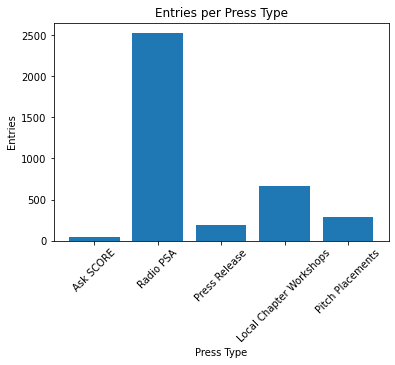

In [394]:
#Total Entries Plot

# Data
x_values = charts['Press Content']
y_values = charts['Total Entries']

# Plotting
plt.bar(x_values, y_values)

# Axis labels
plt.xlabel('Press Type')
plt.ylabel('Entries')

# Title
plt.title('Entries per Press Type')

#So the names do not overlap
plt.xticks(rotation=45)

# Display the plot
plt.show()

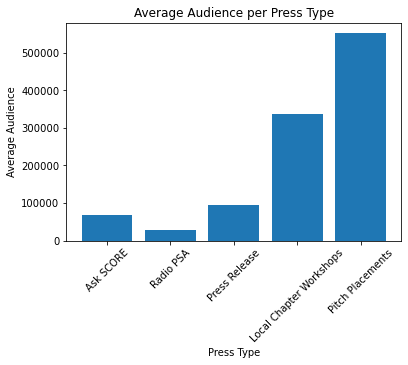

In [395]:
#Average Estimated Audience Plot

# Data
x_values = charts['Press Content']
y_values = charts['Average Estimated National Audience']

# Plotting
plt.bar(x_values, y_values)

# Axis labels
plt.xlabel('Press Type')
plt.ylabel('Average Audience')

# Title
plt.title('Average Audience per Press Type')
plt.xticks(rotation=45)

# Display the plot
plt.show()

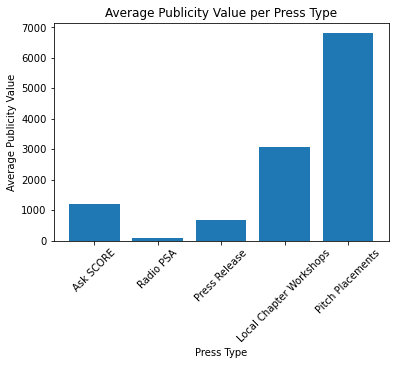

In [396]:
#Total Entries Plot

# Data
x_values = charts['Press Content']
y_values = charts['Average Estimated National Publicity Value']

# Plotting
plt.bar(x_values, y_values)

# Axis labels
plt.xlabel('Press Type')
plt.ylabel('Average Publicity Value')

# Title
plt.title('Average Publicity Value per Press Type')
plt.xticks(rotation=45)

# Display the plot
plt.show()